# Detect High Model Drift 
<b>With this tutorial you:</b><br />
Understand how to use Eurybia to detect datadrift

Contents:
- Detect data drift  
- Compile Drift over years

This public dataset comes from :

https://www.kaggle.com/sobhanmoosavi/us-accidents/version/10

---
Acknowledgements
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.
---

In this tutorial, the data are not loaded raw, a data preparation to facilitate the use of the tutorial has been done. You can find it here : 
https://github.com/MAIF/eurybia/blob/master/eurybia/data/dataprep_US_car_accidents.ipynb

**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [2]:
import pandas as pd
from category_encoders import OrdinalEncoder
import catboost
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

## Import Dataset and split in training and production dataset

In [3]:
from eurybia.data.data_loader import data_loading

In [4]:
df_car_accident = data_loading("us_car_accident")

In [5]:
df_car_accident.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),day_of_week_acc,Nautical_Twilight,season_acc,target,target_multi,year_acc,Description
0,33.0,-117.1,0.0,40.0,93.0,2.0,3,Day,winter,0,2,2019,At Carmel Mountain Rd - Accident.
1,29.5,-98.5,0.0,83.0,65.0,10.0,4,Day,summer,1,3,2017,At TX-345-SP/Woodlawn Ave/Exit 567B - Accident.
2,32.7,-96.8,0.0,88.0,57.0,10.0,0,Night,summer,0,2,2021,Incident on RUGGED DR near BERKLEY AVE Expect ...
3,40.0,-76.3,0.0,61.0,58.0,10.0,4,Day,spring,0,2,2020,At PA-741/Rohrerstown Rd - Accident.
4,41.5,-81.8,1.0,71.0,53.0,10.0,0,Day,summer,0,2,2020,At 117th St/Exit 166 - Accident.


In [6]:
df_car_accident.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),day_of_week_acc,Nautical_Twilight,season_acc,target,target_multi,year_acc,Description
0,33.0,-117.1,0.0,40.0,93.0,2.0,3,Day,winter,0,2,2019,At Carmel Mountain Rd - Accident.
1,29.5,-98.5,0.0,83.0,65.0,10.0,4,Day,summer,1,3,2017,At TX-345-SP/Woodlawn Ave/Exit 567B - Accident.
2,32.7,-96.8,0.0,88.0,57.0,10.0,0,Night,summer,0,2,2021,Incident on RUGGED DR near BERKLEY AVE Expect ...
3,40.0,-76.3,0.0,61.0,58.0,10.0,4,Day,spring,0,2,2020,At PA-741/Rohrerstown Rd - Accident.
4,41.5,-81.8,1.0,71.0,53.0,10.0,0,Day,summer,0,2,2020,At 117th St/Exit 166 - Accident.


In [7]:
df_car_accident.shape

(50000, 13)

In [8]:
# Let us consider that the column "year_acc" corresponds to the reference date. 
#In 2016, a model was trained using data. And in next years, we want to detect data drift on new data in production to predict
df_accident_baseline = df_car_accident.loc[df_car_accident['year_acc'] == 2016]
df_accident_2017 = df_car_accident.loc[df_car_accident['year_acc'] == 2017]
df_accident_2018 = df_car_accident.loc[df_car_accident['year_acc'] == 2018]
df_accident_2019 = df_car_accident.loc[df_car_accident['year_acc'] == 2019]
df_accident_2020 = df_car_accident.loc[df_car_accident['year_acc'] == 2020]
df_accident_2021 = df_car_accident.loc[df_car_accident['year_acc'] == 2021]

In [9]:
#We will train a classification model to predict the severity of an accident. 0 for a less severe accident and 1 for a severe accident.
#Let's check percentage in class 0 and 1
pd.crosstab(df_car_accident.year_acc, df_car_accident.target, normalize = 'index')*100

target,0,1
year_acc,,
2016,71.406287,28.593713
2017,67.254620,32.745380
2018,66.634662,33.365338
2019,79.551182,20.448818
2020,89.944804,10.055196
2021,98.259930,1.740070


In [10]:
y_df_learning=df_accident_baseline['target'].to_frame()
X_df_learning=df_accident_baseline[df_accident_baseline.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2017=df_accident_2017['target'].to_frame()
X_df_2017=df_accident_2017[df_accident_2017.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2018=df_accident_2018['target'].to_frame()
X_df_2018=df_accident_2018[df_accident_2018.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2019=df_accident_2019['target'].to_frame()
X_df_2019=df_accident_2019[df_accident_2019.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2020=df_accident_2020['target'].to_frame()
X_df_2020=df_accident_2020[df_accident_2020.columns.difference(["target", "target_multi", "year_acc", "Description"])]

y_df_2021=df_accident_2021['target'].to_frame()
X_df_2021=df_accident_2021[df_accident_2021.columns.difference(["target", "target_multi", "year_acc", "Description"])]

## Building Supervized Model

In [11]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Visibility(mi)', 'day_of_week_acc', 'Nautical_Twilight',
       'season_acc']

In [12]:
features_to_encode = [col for col in X_df_learning[features].columns if X_df_learning[col].dtype not in ('float64','int64')]

encoder = OrdinalEncoder(cols=features_to_encode)
encoder = encoder.fit(X_df_learning[features])

X_df_learning_encoded=encoder.transform(X_df_learning)

In [13]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [14]:
train_pool_cat = catboost.Pool(data=Xtrain, label= ytrain, cat_features = features_to_encode)
test_pool_cat = catboost.Pool(data=Xtest, label= ytest, cat_features = features_to_encode)

In [15]:
model = catboost.CatBoostClassifier(loss_function= "Logloss", eval_metric="Logloss",
                                    learning_rate=0.143852,
                                    iterations=300,
                                    l2_leaf_reg=15,
                                    max_depth = 4,
                                    use_best_model=True,
                                    custom_loss=['Accuracy', 'AUC', 'Logloss'])

model = model.fit(train_pool_cat, plot=True,eval_set=test_pool_cat, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
proba = model.predict_proba(Xtest)
print(metrics.roc_auc_score(ytest,proba[:,1]))

0.7589233355711246


## Use Eurybia for data validation

In [17]:
from eurybia import SmartDrift

In [18]:
SD = SmartDrift(df_current=X_df_2017,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [19]:
%time
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2017', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )
                 

CPU times: total: 0 ns
Wall time: 0 ns
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.6585689489728102
car_accident_auc.csv did not exist and was created. 


As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

## Add model drift in report

For the moment, the model drift part of eurybia only consists of displaying performance of deployed model. 
(We hope to bring new features in the future on this part)

### Put model performance in DataFrame

In [20]:
proba = model.predict_proba(X_df_2017)
performance = metrics.roc_auc_score(y_df_2017,proba[:,1]).round(5)

In [21]:
#Create Dataframe to track performance over the years
df_performance = pd.DataFrame({'annee': [2017], 'mois':[1], 'performance': [performance]})

In [22]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

In [23]:
SD.generate_report(    
    output_file='report_car_accident_modeldrift_2017.html',    
    title_story="Model drift Report",
    title_description="""US Car accident model drift 2017""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_car_accident.yml" # Optional: add information on report
    )

Report saved to ./report_car_accident_modeldrift_2017.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

This tutorial contains only anlysis on additional features of model drift. For more detailed information on data drift, you can consult these tutorials : (https://github.com/MAIF/eurybia/tree/master/tutorial/model_drift/tutorial02-datadrift-high-datadrift.ipynb)

## Compile Drift over years

### Compile Drift et generate report for Year 2018

In [24]:
SD = SmartDrift(df_current=X_df_2018,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [25]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2018', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7036329129677259


In [26]:
proba = model.predict_proba(X_df_2018)
performance = metrics.roc_auc_score(y_df_2018,proba[:,1]).round(5)
df_performance = df_performance.append({'annee': 2018, 'mois':1, 'performance': performance}, ignore_index=True)

### Compile Drift et generate report for Year 2019

In [27]:
SD = SmartDrift(df_current=X_df_2019,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [28]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2019', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7856527709300022


In [29]:
proba = model.predict_proba(X_df_2019)
performance = metrics.roc_auc_score(y_df_2019,proba[:,1]).round(5)
df_performance = df_performance.append({'annee': 2019, 'mois':1, 'performance': performance}, ignore_index=True)

### Compile Drift et generate report for Year 2020

In [30]:
SD = SmartDrift(df_current=X_df_2020,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [31]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2020', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7902450838961592


In [32]:
proba = model.predict_proba(X_df_2020)
performance = metrics.roc_auc_score(y_df_2020,proba[:,1]).round(5)
df_performance = df_performance.append({'annee': 2020, 'mois':1, 'performance': performance}, ignore_index=True)

### Compile Drift et generate report for Year 2021

In [33]:
SD = SmartDrift(df_current=X_df_2021,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [34]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2021', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.7500011519622525


In [35]:
proba = model.predict_proba(X_df_2021)
performance = metrics.roc_auc_score(y_df_2021,proba[:,1]).round(5)
df_performance = df_performance.append({'annee': 2021, 'mois':1, 'performance': performance}, ignore_index=True)

In [36]:
SD.add_data_modeldrift(dataset=df_performance,metric='performance') 

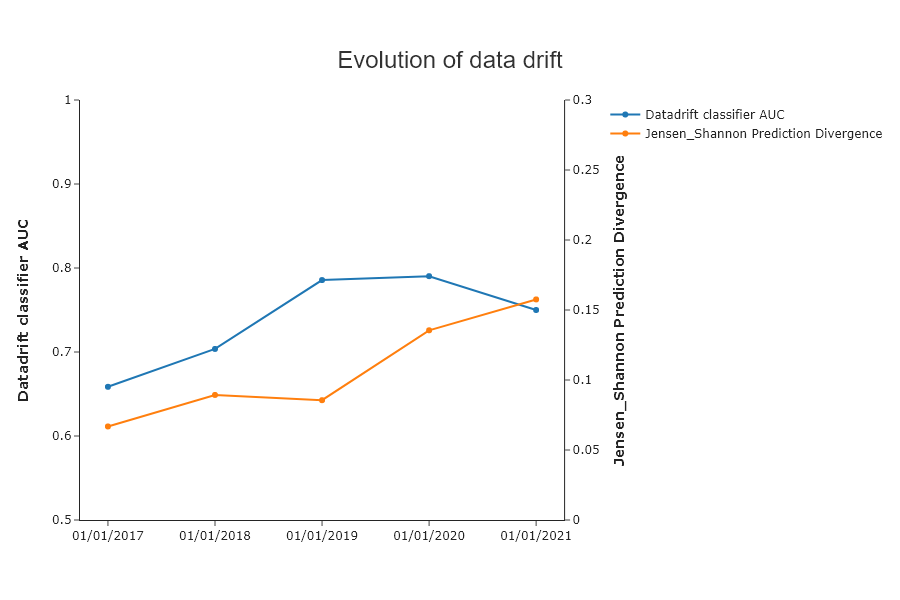

In [37]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

In 2019 and 2020, data drift is very high. In 2021 data drift is decreasing. Is there any impact on the performance of the model?

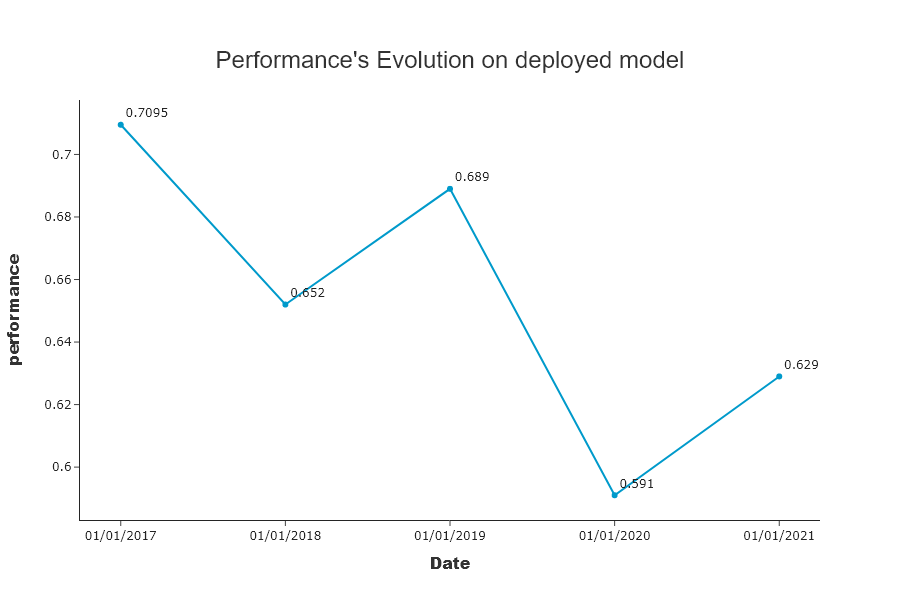

In [38]:
SD.plot.generate_modeldrift_data() # works if add_data_modeldrift used before                

While data drift was high in 2019, the impact on model performance is low. In 2020, data drift leads to a decrease in model performance. As data drift decreases in 2021 the performance of the model goes back up.

In [39]:
SD.generate_report(    
    output_file='report_car_accident_modeldrift_2021.html',    
    title_story="Model drift Report",
    title_description="""US Car accident model drift 2021""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_car_accident.yml" # Optional: add information on report
    ) 

Report saved to ./report_car_accident_modeldrift_2021.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.